In [1]:
%load_ext lab_black
%load_ext autotime
import numpy as np
import pandas as pd

time: 456 ms (started: 2023-03-30 18:51:51 -07:00)


The [Online Encyclopedia of Integer Sequences](https://oeis.org/) were subjected to dimensionality reduction (t-SNE, UMAP, PaCMAP) in [a tweet](https://twitter.com/christopher/status/1641106960329351168) by Christopher Akiki. The sequences are treated like words in a document and subjected to TF-IDF. 
The data is available has been made available in a convenient format by Christopher Akiki at [huggingface](https://huggingface.co/datasets/cakiki/oeis). 
Note that to read parquet files with `pandas` you need an external library. I am using [pyarrow](https://arrow.apache.org/docs/python/index.html). 
Also, at the time I downloaded the data, it was noted in the README that it was a work in progress.

In [2]:
df = pd.read_parquet(
    "https://huggingface.co/datasets/cakiki/oeis/resolve/main/data/train-00000-of-00001-695ab9f8a0a0fa0c.parquet",
    engine="pyarrow",
)

time: 7.98 s (started: 2023-03-30 18:51:51 -07:00)


In [3]:
df

,a-number,sequence,description
0,A000001,"[0, 1, 1, 1, 2, 1, 2, 1, 5, 2, 2, 1, 5, 1, 2, ...",Number of groups of order n.
1,A000002,"[1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, ...",Kolakoski sequence: a(n) is length of n-th run...
2,A000003,"[1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 4, 2, ...",Number of classes of primitive positive defini...
3,A000004,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The zero sequence.
4,A000005,"[1, 2, 2, 3, 2, 4, 2, 4, 3, 4, 2, 6, 2, 4, 4, ...","d(n) (also called tau(n) or sigma_0(n)), the n..."
...,...,...,...
361591,A361881,"[1, 3, 15, 93, 618, 4278, 30390, 219810, 16111...",Expansion of 1/(1 - 9*x/(1 + x))^(1/3).
361592,A361882,"[1, 3, 12, 63, 357, 2112, 12834, 79446, 498504...",Expansion of 1/(1 - 9*x/(1 + x)^2)^(1/3).
361593,A361893,"[1, 0, 1, 0, 2, 2, 0, 3, 12, 6, 0, 4, 36, 72, ...","Triangle read by rows. T(n, k) = n! * binomial..."
361594,A361895,"[1, 3, 27, 252, 2487, 25434, 266364, 2837082, ...",Expansion of 1/(1 - 9*x/(1 - x)^3)^(1/3).


time: 16.8 ms (started: 2023-03-30 18:51:59 -07:00)


Each row in the `sequence` column is a numpy array of integers. To turn that into documents that the vectorizer can use, first we will join each array on whitespace to create a string, then extract each array, to create a python list of strings:

In [4]:
text = [
    x[0] for x in df[["sequence"]].apply(lambda x: np.char.join(" ", x)).values.tolist()
]

time: 2.19 s (started: 2023-03-30 18:51:59 -07:00)


In [5]:
text[0]

'0 1 1 1 2 1 2 1 5 2 2 1 5 1 2 1 14 1 5 1 5 2 2 1 15 2 2 5 4 1 4 1 51 1 2 1 14 1 2 2 14 1 6 1 4 2 2 1 52 2 5 1 5 1 15 2 13 2 2 1 13 1 2 4 267 1 4 1 5 1 4 1 50 1 2 3 4 1 6 1 52 15 2 1 15 1 2 1 12 1 10 1 4 2'

time: 3.57 ms (started: 2023-03-30 18:52:02 -07:00)


Any duplicates?

In [6]:
len(text) - len(set(text))

2487

time: 104 ms (started: 2023-03-30 18:52:02 -07:00)


So a couple of thousand of the sequences are the same, but less than 1% of the entire dataset. Now for the Tf-Idf part. Just going to use the defaults here (so using smoothed IDF with L2 normalization):

In [7]:
import sklearn.feature_extraction.text

tfidf = sklearn.feature_extraction.text.TfidfVectorizer().fit_transform(text)

time: 17.8 s (started: 2023-03-30 18:52:02 -07:00)


In [8]:
tfidf.shape

(361596, 1763601)

time: 3.01 ms (started: 2023-03-30 18:52:20 -07:00)


More than 1 million columns! You would not want to make that into a dense matrix directly. As this [subsequent tweet](https://twitter.com/christopher/status/1641171237513703424) indicates, the results of the TF-IDF are pre-processed down to 160D. This is likely to take a few minutes and use ~10GB of RAM.

In [9]:
import sklearn.decomposition

tsvd = sklearn.decomposition.TruncatedSVD(n_components=160).fit(tfidf)

time: 4min 31s (started: 2023-03-30 18:52:20 -07:00)


In [10]:
np.sum(tsvd.explained_variance_ratio_)

0.24562383809265653

time: 6.51 ms (started: 2023-03-30 18:56:52 -07:00)


25% of variance explained. Maybe a little low?

In [11]:
data = tsvd.transform(tfidf)

time: 4.2 s (started: 2023-03-30 18:56:52 -07:00)


Not sure how the sequences are colored so we won't do anything with that (we'll color by index). The second tweet mentions normalization, but that may refer to the normalization done as part of the Tf-Idf process, so as long as we do some normalization we're good.

In [12]:
from drnb.io.pipeline import create_default_pipeline

_ = create_default_pipeline(check_for_duplicates=True, metric=["euclidean"]).run(
    "oeis",
    data=data,
    url="https://huggingface.co/datasets/cakiki/oeis",
    verbose=True,
)

[18:57:00] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=446279;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=444347;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#566\566]8;;\

           INFO     Initial data shape: (361596, 160)                                                ]8;id=689717;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=264995;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#75\75]8;;\

           INFO     Keeping all columns                                                            ]8;id=783735;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=862119;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Data shape after filtering columns: (361596, 160)                               ]8;id=111862;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=450464;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=486648;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=734741;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#130\130]8;;\

           INFO     Data shape after filtering NAs: (361596, 160)                                   ]8;id=362319;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=41897;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#141\141]8;;\

[18:57:03] INFO     Checked for duplicates: found 42331                                             ]8;id=501322;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=404667;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#153\153]8;;\

           INFO     No scaling                                                                     ]8;id=869232;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=699947;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=402620;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=201233;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     Writing data for oeis                                                           ]8;id=445071;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=641023;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#226\226]8;;\

[18:58:13] INFO     Calculating nearest neighbors                                                   ]8;id=859964;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=677510;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#241\241]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=469200;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=604626;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=6048;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=609454;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=725266;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=960610;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=285013;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=996920;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

           INFO     Using 'faiss' to find nearest neighbors                                          ]8;id=541362;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=827741;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#81\81]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=16654;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=125577;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#94\94]8;;\

[18:58:32] INFO     Writing numpy format to nn/oeis.16.euclidean.exact.faiss.idx.npy                ]8;id=600397;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=202404;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[18:59:07] INFO     Writing csv format to nn/oeis.16.euclidean.exact.faiss.idx.csv                  ]8;id=377913;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=939800;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[18:59:13] INFO     Writing numpy format to nn/oeis.16.euclidean.exact.faiss.dist.npy               ]8;id=51970;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=568926;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[18:59:30] INFO     Writing csv format to nn/oeis.16.euclidean.exact.faiss.dist.csv                 ]8;id=549313;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=106018;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[18:59:37] INFO     Writing numpy format to nn/oeis.51.euclidean.exact.faiss.idx.npy                ]8;id=927847;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=706793;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[19:01:25] INFO     Writing csv format to nn/oeis.51.euclidean.exact.faiss.idx.csv                  ]8;id=886178;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=449973;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:01:41] INFO     Writing numpy format to nn/oeis.51.euclidean.exact.faiss.dist.npy               ]8;id=815988;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=835587;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[19:02:35] INFO     Writing csv format to nn/oeis.51.euclidean.exact.faiss.dist.csv                 ]8;id=15065;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=802970;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:02:55] INFO     Writing numpy format to nn/oeis.151.euclidean.exact.faiss.idx.npy               ]8;id=820132;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=341784;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[19:02:56] INFO     Writing csv format to nn/oeis.151.euclidean.exact.faiss.idx.csv                 ]8;id=557404;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=798080;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:03:41] INFO     Writing numpy format to nn/oeis.151.euclidean.exact.faiss.dist.npy              ]8;id=382549;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=701371;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/oeis.151.euclidean.exact.faiss.dist.csv                ]8;id=614269;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=727588;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:04:47] INFO     Calculating triplets                                                            ]8;id=868271;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=726448;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#252\252]8;;\

[19:04:48] INFO     Writing csv format to triplets/oeis.5.1337.idx.csv                              ]8;id=145722;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=464534;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:04:55] INFO     Writing csv format to triplets/oeis.5.1337.euclidean.csv                        ]8;id=555815;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=316046;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[19:05:02] INFO     Writing numpy format to triplets/oeis.5.1337.idx.npy                            ]8;id=408921;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=534620;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing numpy format to triplets/oeis.5.1337.euclidean.npy                      ]8;id=696852;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=578111;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing pipeline result for oeis                                                ]8;id=943195;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=610298;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#123\123]8;;\

time: 8min 6s (started: 2023-03-30 18:56:56 -07:00)


After TF-IDF and SVD there were 42,330 duplicate rows, a little over 10% of the dataset. An order of magnitude increase over the the duplicates in the original data. Anyway, let's see how this looks with PCA.

In [13]:
import drnb.embed.pipeline as pl

time: 3.33 s (started: 2023-03-30 19:05:02 -07:00)


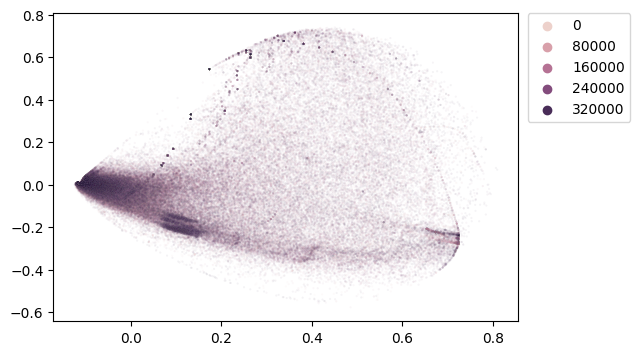

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6999413710328654, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.8298414503791163, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.032080922724071426, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.03666755163220833, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.03768706880975821, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 53.3 s (started: 2023-03-30 19:05:06 -07:00)


In [14]:
pl.standard_eval(
    method="pca",
    dataset="oeis",
)

Not a whole lot going on there. Now for some UMAP. I got a complaint about the graph being disconnected with `n_neighbors=15`, so to avoid any issues with the spectral initialization, I have gone up to `n_neighbors=50`:

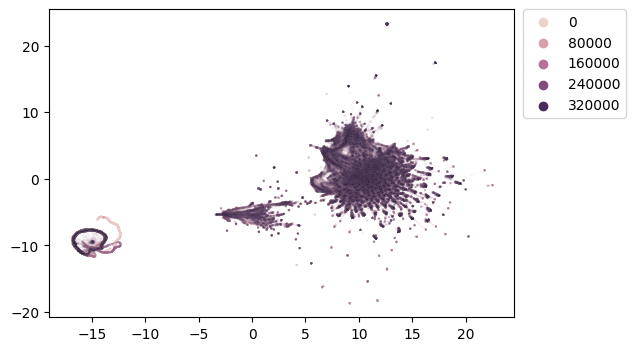

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.44045951835750397, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=-0.13374739748189257, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.1040225371224608, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.15447421984756468, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.17731652636275477, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 8min 50s (started: 2023-03-30 19:05:59 -07:00)


In [15]:
pl.standard_eval(
    method="umap",
    params=dict(n_neighbors=50),
    dataset="oeis",
)

Alright, there are some shapes there. Doesn't look that much like the tweet but that can be explained by any combination of:

* the TF-IDF procedure
* the normalization
* the nearest neighbor calculation
* the number of neighbors